In [115]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import tree
import scipy.io as sio

In [6]:
"""
data = sio.loadmat('mnist.mat')


Xtrain = data['trainX'][:10000,:].astype(int)
Xtest = data['testX'].astype(int)
ytrain =data['trainY'][0,:10000].astype(int)
ytest =  data['testY'][0,:].astype(int)

idx = np.logical_or(np.equal(ytrain,4), np.equal(ytrain,9))
Xtrain = Xtrain[idx,:]
ytrain = ytrain[idx]
ytrain[np.equal(ytrain,4)] = 1
ytrain[np.equal(ytrain,9)] = -1

idx = np.logical_or(np.equal(ytest,4), np.equal(ytest,9))
Xtest = Xtest[idx,:]
ytest = ytest[idx]
ytest[np.equal(ytest,4)] = 1
ytest[np.equal(ytest,9)] = -1


sio.savemat('mnist_binary_small.mat',{'Xtrain':Xtrain,'ytrain':ytrain,'Xtest':Xtest,'ytest':ytest})

"""

data = sio.loadmat('../mnist_adaboost_release/mnist_binary_small.mat')


Xtrain, Xtest, ytrain, ytest = data["Xtrain"], data["Xtest"], data["ytrain"], data["ytest"]

In [8]:
print (Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
print (type(Xtrain), type(Xtest), type(ytrain), type(ytest))

(1958, 784) (1991, 784) (1, 1958) (1, 1991)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [156]:
class Adaboost:
    def __init__(self, weak_learners:int, m:int=1):
        np.random.seed(42)
        tree_params = {'criterion':'entropy','max_depth':1,'class_weight':'balanced'}
        tree_params["splitter"] = 'best' if weak_learners == 1 else 'random'
        self.stumps = [tree.DecisionTreeClassifier(**tree_params) for i in range(weak_learners)]
        self.w = None
        self.w_hat = None
        self.m = m
        self.init_w()
        self.alpha = np.zeros((weak_learners,))

        self.train_loss = []
        self.train_pred_agg = []
        self.eval_loss = []
        self.eval_pred_agg = []
        self.alpha_t = []
        self.epsilon_t = []
        self.t = []

    def init_w(self):
        self.w = np.ones((self.m, ))/self.m
        self.w_hat = np.empty((self.m,))
    
    def train_stumps(self, X:np.ndarray, y:np.ndarray):
        y = y.reshape(-1, )
        for stump in self.stumps:
            stump.fit(X, y)

    def stumps_prediction(self, X:np.ndarray):
        return [stump.predict(X) for stump in self.stumps]

    def loss(self, y:np.ndarray, y_hat:np.ndarray):
        return np.mean(np.exp(-y*y_hat))

    def fit(self, X:np.ndarray, y:np.ndarray, eval_every_epoch:bool=False, X_eval:np.ndarray = None,\
            y_eval:np.ndarray=None):

        if X.shape[0] != self.m:
            self.m = X.shape[0]
            self.init_w()
        
        y = y.reshape(-1, )
        self.train_stumps(X, y)

        for t in range(len(self.stumps)):
            #Adaboost training
            all_epsilon_t = [np.sum(self.w[pred != y]) for pred in self.stumps_prediction(X)]
            iter_t, iter_epsilon_t = np.argmin(all_epsilon_t), np.min(all_epsilon_t)
            iter_alpha_t = 1/2*np.log((1 - iter_epsilon_t)/iter_epsilon_t)
            self.alpha[iter_t] = iter_alpha_t
            self.w_hat = self.w*np.exp(-iter_alpha_t*y*self.stumps[iter_t].predict(X))
            self.w = self.w_hat/np.sum(self.w_hat)

            #Saving iter measures
            self.alpha_t.append((t, iter_alpha_t))
            self.epsilon_t.append((t, iter_epsilon_t))
            self.t.append((t, iter_t))

            #Saving iter train predictions and loss
            _, pred_agg = self.predict(X)
            self.train_pred_agg.append((t, pred_agg))
            self.train_loss.append((t, self.loss(ytrain, pred_agg)))

            #Saving iter eval predictions and loss
            if eval_every_epoch:
                _, pred_agg = self.predict(X_eval)
                self.eval_pred_agg.append((t, pred_agg))
                self.eval_loss.append((t, self.loss(y_eval, pred_agg)))

        return self

    def predict(self, X:np.ndarray):
        sign_fn = lambda x: -1 if x<0 else 1

        preds, preds_agg = [], []
        for x in X:
            pred_val = 0
            for t, stump in enumerate(self.stumps):
                pred_val += self.alpha[t]*stump.predict(x.reshape(1, -1))
            preds.append(sign_fn(pred_val))
            preds_agg.append(pred_val)
        
        return np.array(preds), np.array(preds_agg)

sign_fn = lambda x: -1 if x<0 else 1

def miss_rate(y_true, y_pred):
    y_true, y_pred = y_true.reshape(-1, ), y_pred.reshape(-1, )
    return np.sum(y_true != y_pred)/len(y_true)

In [109]:
'''
    Without Adaboost training for 1 decision stump
'''
clf = Adaboost(weak_learners = 1)
clf.train_stumps(Xtrain, ytrain)
clf.alpha = np.array([1])
ypred, ypred_agg = clf.predict(Xtrain)
print (f"Train Miss rate of stump: {np.around(miss_rate(ytrain, ypred), 3)}")
print (f"Train loss: {np.around(clf.loss(ytrain, ypred_agg), 3)}")
ypred, ypred_agg = clf.predict(Xtest)
print (f"Test Miss rate of stump: {np.around(miss_rate(ytest, ypred), 3)}")

Train Miss rate of stump: 0.11
Train loss: 1.543
Test Miss rate of stump: 0.153


In [110]:
'''
    With Adaboost training for the same decision stump
'''
clf = Adaboost(weak_learners = 1)
clf.fit(Xtrain, ytrain)
ypred, ypred_agg = clf.predict(Xtrain)
print (f"Train Miss rate of stump: {np.around(miss_rate(ytrain, ypred), 3)}")
print (f"Train loss: {np.around(clf.loss(ytrain, ypred_agg), 3)}")
ypred, ypred_agg = clf.predict(Xtest)
print (f"Test Miss rate of stump: {np.around(miss_rate(ytest, ypred), 3)}")

Train Miss rate of stump: 0.11
Train loss: 1.599
Test Miss rate of stump: 0.153


In [114]:
'''
    Adaboost by varying t 
'''
train_losses, eval_losses = [], []
train_pred_aggs, eval_pred_aggs = [], []
epsilon_ts, alpha_ts = [], []
clfs = []
for learners in range(5):
    clf = Adaboost(weak_learners = 2**learners)
    clf.fit(Xtrain, ytrain, True, Xtest, ytest)
    
    train_losses.append(clf.train_loss)
    eval_losses.append(clf.eval_loss)
    train_pred_aggs.append(clf.train_pred_agg)
    eval_pred_aggs.append(clf.eval_pred_agg)
    epsilon_ts.append(clf.epsilon_t)
    alpha_ts.append(clf.alpha_t)
    clfs.append(clf)

    ypred, ypred_agg = clf.predict(Xtrain)
    print (f"Train Miss rate of {2**learners} stumps: {np.around(miss_rate(ytrain, ypred), 3)}")
    print (f"Train loss of {2**learners} stumps: {np.around(clf.loss(ytrain, ypred_agg), 3)}")
    ypred, ypred_agg = clf.predict(Xtest)
    print (f"Test Miss rate of {2**learners} stumps: {np.around(miss_rate(ytest, ypred), 3)}")    
    print ("--------------------------------------------------")

Train Miss rate of 1 stumps: 0.11
Train loss of 1 stumps: 1.599
Test Miss rate of 1 stumps: 0.153
--------------------------------------------------
Train Miss rate of 2 stumps: 0.122
Train loss of 2 stumps: 2.022
Test Miss rate of 2 stumps: 0.166
--------------------------------------------------
Train Miss rate of 4 stumps: 0.124
Train loss of 4 stumps: 2.03
Test Miss rate of 4 stumps: 0.168
--------------------------------------------------
Train Miss rate of 8 stumps: 0.11
Train loss of 8 stumps: 2.0
Test Miss rate of 8 stumps: 0.157
--------------------------------------------------
Train Miss rate of 16 stumps: 0.112
Train loss of 16 stumps: 2.247
Test Miss rate of 16 stumps: 0.154
--------------------------------------------------


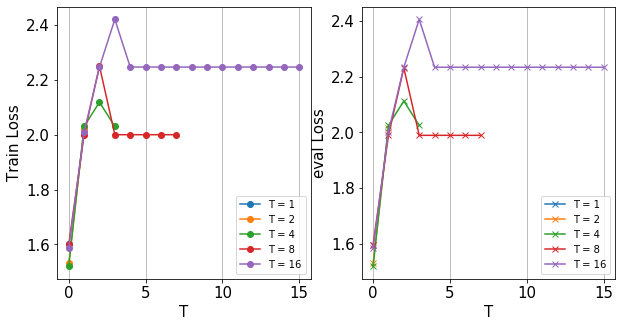

In [137]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for t in range(5):
    axs[0].plot(np.arange(2**t), np.array(train_losses[t])[:, 1], label=f"T = {2**t}", marker="o")
    axs[1].plot(np.arange(2**t), np.array(eval_losses[t])[:, 1], label=f"T = {2**t}", marker="x")

axs[0].set_ylabel("Train Loss", fontsize=15)
axs[1].set_ylabel("eval Loss", fontsize=15)

for i in range(2):
    axs[i].set_xlabel("T", fontsize=15)
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    axs[i].grid(axis="x")
    axs[i].legend()

plt.show()


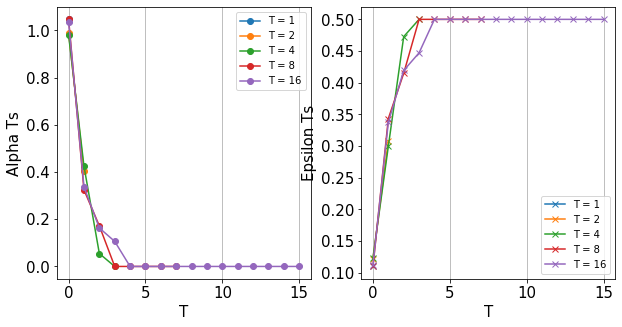

In [136]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for t in range(5):
    axs[0].plot(np.arange(2**t), np.array(alpha_ts[t])[:, 1], label=f"T = {2**t}", marker="o")
    axs[1].plot(np.arange(2**t), np.array(epsilon_ts[t])[:, 1], label=f"T = {2**t}", marker="x")

axs[0].set_ylabel("Alpha Ts", fontsize=15)
axs[1].set_ylabel("Epsilon Ts", fontsize=15)

for i in range(2):
    axs[i].set_xlabel("T", fontsize=15)
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    axs[i].grid(axis="x")
    axs[i].legend()

plt.show()


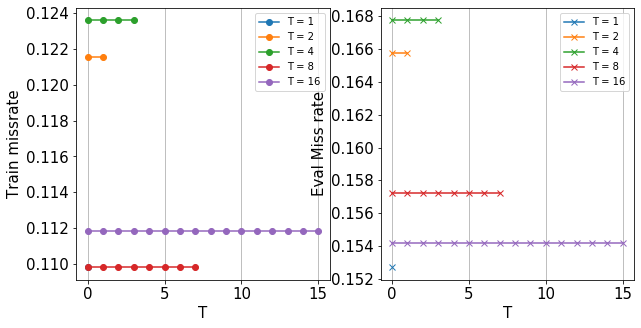

In [164]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for t in range(5):
    train_miss_rate = [miss_rate(ytrain, np.array(list(map(sign_fn, preds))) ) for i, preds in train_pred_aggs[t]]
    eval_miss_rate = [miss_rate(ytest, np.array(list(map(sign_fn, preds))) ) for i, preds in eval_pred_aggs[t]]
    axs[0].plot(np.arange(2**t), np.array(train_miss_rate), label=f"T = {2**t}", marker="o")
    axs[1].plot(np.arange(2**t), np.array(eval_miss_rate), label=f"T = {2**t}", marker="x")

axs[0].set_ylabel("Train missrate", fontsize=15)
axs[1].set_ylabel("Eval Miss rate", fontsize=15)

for i in range(2):
    axs[i].set_xlabel("T", fontsize=15)
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    axs[i].grid(axis="x")
    axs[i].legend()

plt.show()
